In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 绘制季节循环的时间序列

2021.12.22

进行了季节循环的整个空间平均的计算，并且处理到了和观测相同的时间上，用于计算误差，以及统计量，在图中通过制表来表达

由于处理部分过多，气温和降水分开在不同脚本运行

## 数据读入

In [6]:
path_in = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip_mask/"
ds_in = {}
dir_obs_in ="/raid61/LS4P-TPEMIP/REFERENCE/CN05.1/"
ds_in['obs'] = xr.open_dataset(dir_obs_in + "sel_CN05.1_Pre_1961_2018_daily_025x025.nc").rename({"pre":"pr"})
# ds_in[''] = xr.open_dataset(path_in + "")
ds_in['CWRF'] = xr.open_dataset(path_in + "CWRF_pre.nc")  # 缺少逐日数据，只有多种尺度的平均态数据
ds_in['JAMSTECWRF'] = xr.open_dataset(path_in + "JAMSTECWRF_pre.nc") # 缺少4月
ds_in['NJU_LS4P_B'] = xr.open_dataset(path_in + "NJU_LS4P_B_pre.nc") 
ds_in['NJU_LS4P_C'] = xr.open_dataset(path_in + "NJU_LS4P_C_pre.nc") 
ds_in['NJU_Output-E'] = xr.open_dataset(path_in + "NJU_Output-E_pre.nc") # 缺少2015年
ds_in['SYS'] = xr.open_dataset(path_in + "SYS_pre.nc") 
ds_in['Yang-ZhouX'] = xr.open_dataset(path_in + "Yang-ZhouX_pre.nc") 
ds_in['YSU'] = xr.open_dataset(path_in + "YSU_pre.nc") 

In [7]:
# 稍微处理一下变量名，用于后续的处理
for single_mod in ds_in:
    print(single_mod)
    list_vars = list(ds_in[single_mod].variables)
    print(list_vars)
#     print(ds_in[single_mod].coords)
    if ('Time' in list_vars):
        print('----- rename Time>>>time')
        ds_in[single_mod] = ds_in[single_mod].rename({"Time":"time"})

obs
['time', 'lon', 'lat', 'pr']
CWRF
['pr', 'lon', 'lat', 'time']
JAMSTECWRF
['pr', 'lon', 'lat', 'time']
NJU_LS4P_B
['pr', 'lon', 'lat', 'time']
NJU_LS4P_C
['pr', 'lon', 'lat', 'time']
NJU_Output-E
['pr', 'lon', 'lat', 'time']
SYS
['pr', 'lon', 'lat', 'time']
Yang-ZhouX
['pr', 'lon', 'lat', 'time']
YSU
['pr', 'lon', 'lat', 'time']


## 计算部分

### 整理季节时间序列

In [9]:
var_seasonal_ts = {}

for mod_name in ds_in:


    temp_var = ds_in[mod_name].groupby(ds_in[mod_name].time.dt.dayofyear).mean(dim = 'time')
    dayofyear = temp_var.dayofyear
#     sel_dayofyear = (dayofyear >=92) & (dayofyear <= 244) # select 04-01 to 08-31
#     temp_var = temp_var.isel({"dayofyear":sel_dayofyear}) # create new time (day of year)
    
    if (mod_name == "CWRF"):
        new_time_pd = pd.date_range("2004-04-01", "2004-08-31", freq= 'M') # add new time coords
        sel_dayofyear = (dayofyear >=92) & (dayofyear <= 244) # select 04-01 to 08-31
        temp_var = temp_var.isel({"dayofyear":sel_dayofyear}) # create new time (day of year)
    elif (mod_name == "JAMSTECWRF"):
        new_time_pd = pd.date_range("2004-05-01", "2004-08-31", freq= 'D') # add new time coords
        sel_dayofyear = (dayofyear >=122) & (dayofyear <= 244) # select 04-01 to 08-31
        temp_var = temp_var.isel({"dayofyear":sel_dayofyear}) # create new time (day of year)
    else:
        new_time_pd = pd.date_range("2004-04-01", "2004-08-31", freq= 'D') # add new time coords
        sel_dayofyear = (dayofyear >=92) & (dayofyear <= 244) # select 04-01 to 08-31
        temp_var = temp_var.isel({"dayofyear":sel_dayofyear}) # create new time (day of year)

    new_time_da = xr.DataArray(new_time_pd, name = 'dayofyear' ,dims = 'time')
    temp_var = temp_var.rename({"dayofyear":"time"}).assign_coords({"time":new_time_da})
    var_seasonal_ts[mod_name] = temp_var['pr'].mean(dim = ["lat","lon"])
    del(temp_var)

### 计算时间序列做差

In [24]:
var_seasonal_ts_diff = {}
mod_list =  ['obs','CWRF','JAMSTECWRF', 'NJU_LS4P_B', 'NJU_LS4P_C', 'NJU_Output-E', 'SYS', 'Yang-ZhouX', 'YSU']
for mod_name in mod_list:
    if (mod_name == 'CWRF'):
        obs_temp = var_seasonal_ts['obs'].groupby(var_seasonal_ts['obs'].time.dt.month).mean(dim = 'time').values
        var_seasonal_ts_diff[mod_name] = var_seasonal_ts['CWRF'] - obs_temp
    else:
        var_seasonal_ts_diff[mod_name] = var_seasonal_ts[mod_name] - var_seasonal_ts['obs']        

### 计算统计量诸要素

In [11]:
import skill_metrics as sm
metrics_ts = {}
var_seasonal_ts_obs_samelength = {}
var_list =  ['CWRF','JAMSTECWRF', 'NJU_LS4P_B', 'NJU_LS4P_C', 'NJU_Output-E', 'SYS', 'Yang-ZhouX', 'YSU']
metrics_ts = pd.DataFrame(index = var_list, columns=['Bias','RMSE','Corr.']) 
for imod in var_list:
    temp_mod =  var_seasonal_ts[imod].values
    # 处理不对应的时间
    if (imod == 'CWRF'):
        obs_temp = var_seasonal_ts['obs'].groupby(var_seasonal_ts['obs'].time.dt.month).mean(dim = 'time')
        temp_obs =  obs_temp.values
    elif (imod == 'JAMSTECWRF'):
        temp_obs = var_seasonal_ts['obs'].sel(time = var_seasonal_ts['JAMSTECWRF'].time).values
    else:
        temp_obs =  var_seasonal_ts['obs'].values

    metrics_ts.loc[imod]['Bias'] = sm.bias(temp_mod, temp_obs)
    metrics_ts.loc[imod]['RMSE'] = sm.rmsd(temp_mod, temp_obs)
    metrics_ts.loc[imod]['Corr.'] = np.corrcoef(temp_mod, temp_obs)[0,1]

In [12]:
metrics_ts

,Bias,RMSE,Corr.
CWRF,0.614021,0.629893,0.993801
JAMSTECWRF,-0.230723,0.432053,0.848806
NJU_LS4P_B,1.79375,1.85417,0.978763
NJU_LS4P_C,1.47308,1.51474,0.97439
NJU_Output-E,1.65127,1.69965,0.973807
SYS,1.82983,1.91919,0.970087
Yang-ZhouX,1.19326,1.3058,0.977681
YSU,1.60014,1.75277,0.877544


In [27]:
var_seasonal_ts_rollmean = {}
for mod_name in ds_in:
    if (mod_name == 'CWRF'):
        var_seasonal_ts_rollmean[mod_name] = var_seasonal_ts[mod_name]
    else:
        var_seasonal_ts_rollmean[mod_name] = var_seasonal_ts[mod_name].rolling(time=10, center=True).mean()
        
var_seasonal_ts_diff = {}
mod_list =  ['obs','CWRF','JAMSTECWRF', 'NJU_LS4P_B', 'NJU_LS4P_C', 'NJU_Output-E', 'SYS', 'Yang-ZhouX', 'YSU']
for mod_name in mod_list:
    if (mod_name == 'CWRF'):
        obs_temp = var_seasonal_ts['obs'].groupby(var_seasonal_ts_rollmean['obs'].time.dt.month).mean(dim = 'time').values
        var_seasonal_ts_diff[mod_name] = var_seasonal_ts_rollmean['CWRF'] - obs_temp
    else:
        var_seasonal_ts_diff[mod_name] = var_seasonal_ts_rollmean[mod_name] - var_seasonal_ts_rollmean['obs']        

## 绘图部分

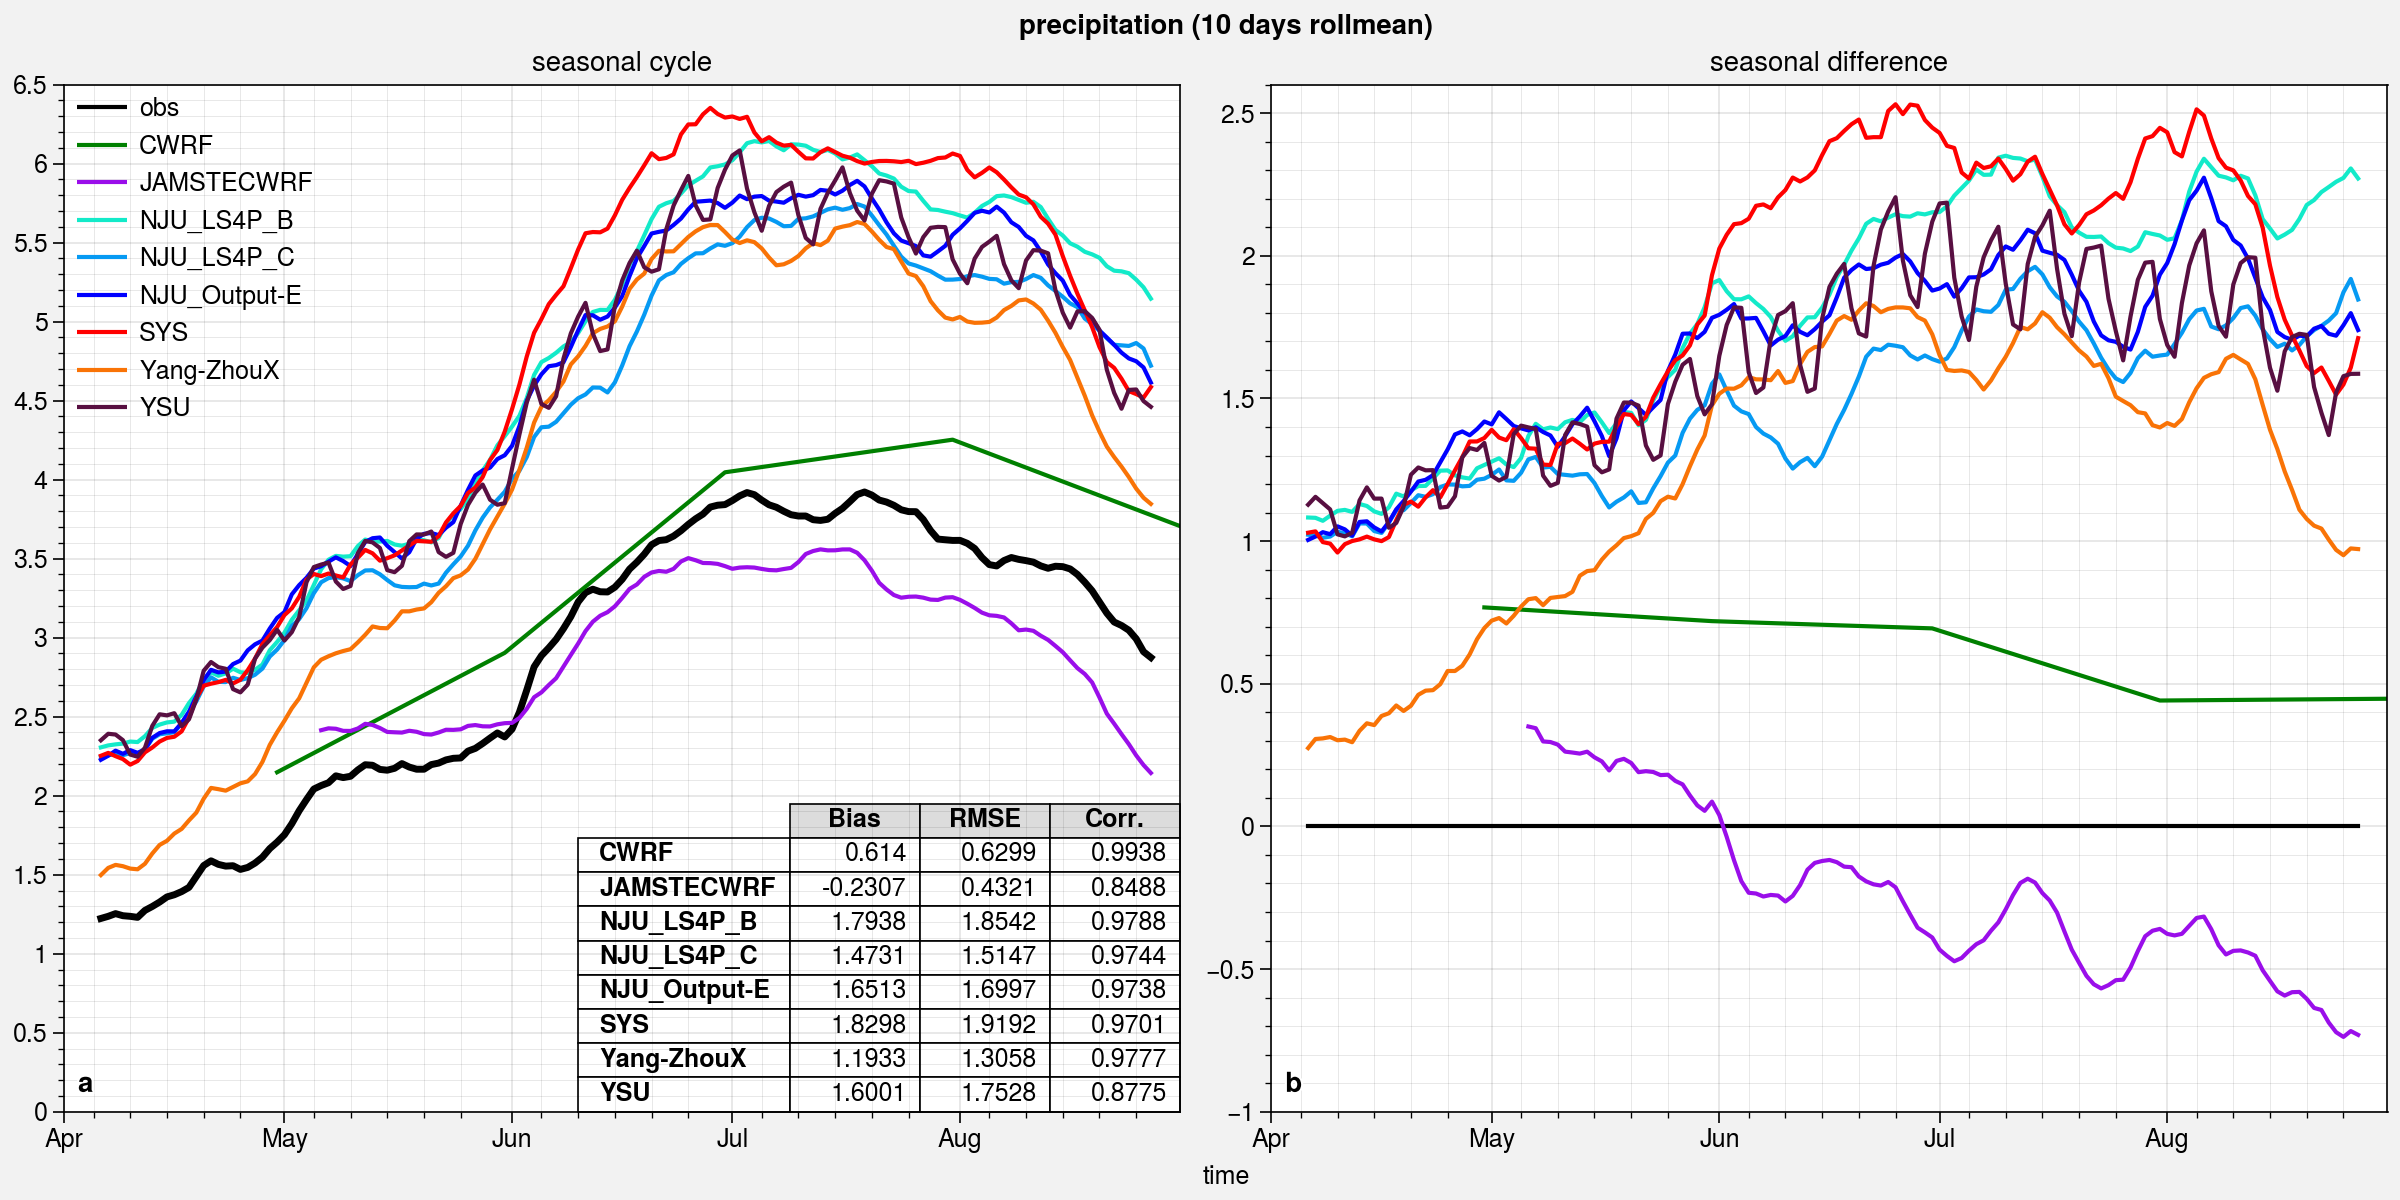

In [33]:
from matplotlib import pyplot as plt
import proplot as pplt
#----- create plot -----
fig, axs = pplt.subplots(ncols=2 ,nrows=1, share=1, figsize = (12,6))
color_loops = ['k','green','violet','aqua','azure','blue','red','orange','plum']
mod_list =  ['obs','CWRF','JAMSTECWRF', 'NJU_LS4P_B', 'NJU_LS4P_C', 'NJU_Output-E', 'SYS', 'Yang-ZhouX', 'YSU']
ind = 0
m_plot_list = []
for mod_name in mod_list:
    if (mod_name  == 'obs'):
        m_plot = axs[0].plot(var_seasonal_ts_rollmean[mod_name].time, var_seasonal_ts_rollmean[mod_name].values, label = mod_name, color=color_loops[ind],\
                            linewidth = 2.5)
    m_plot = axs[0].plot(var_seasonal_ts_rollmean[mod_name].time, var_seasonal_ts_rollmean[mod_name].values, label = mod_name, color=color_loops[ind],\
                linewidth = 1.5)
    m_diffplot = axs[1].plot(var_seasonal_ts_diff[mod_name].time, var_seasonal_ts_diff[mod_name].values, label = mod_name, color=color_loops[ind],\
                    linewidth = 1.5)
    ind = ind + 1
    m_plot_list.append(m_plot)
# 统一设置时间型format
axs.format(
    abc = True,
    abcloc = 'll',
    # -----
    xlim=(np.datetime64('2004-04-01'), np.datetime64('2004-08-31')),
    ylim = (0,6.5),
    ylocator = .5,
    # yminorlocator = np.arange(0,1.4,0.1),
    yminorlocator = 0.1,
    # ----- time ticks setting -----
    xrotation = False,
    xgrid = True,
    xgridminor = True,
    ygridminor = True,
    xminorlocator=('day',range(0,30,5)),
    xlocator=('month',range(0,12,1)),
    xformatter = '%b', #title='Ticks every N units',
    suptitle = 'precipitation (10 days rollmean)',
    title = 'seasonal cycle'
)
axs[1].format(ylim = (-1,2.6), ylocator = .5, yminorlocator = 0.1,title = 'seasonal difference')
axs[0].legend(m_plot_list, loc='ul', ncols=1, frame=False)

# ----- add table on axis -----
# 参考回答：https://stackoverflow.com/questions/54150557/how-to-show-dataframe-index-name-on-a-matplotlib-table
# 使用bbox调整表格的大小
plot_table = metrics_ts
table = axs[0].table(cellText=np.matrix.round(plot_table.values.astype('float'),4),\
     rowLabels=var_list, colLabels=plot_table.columns, loc = 'upper left',colColours=['gainsboro'] * 3,\
         colWidths = [0.1]*3, bbox = [0.65, 0.0, 0.35, 0.3])
# table.set_fontweight('roman')
            #  colColours=['gainsboro'] * len(plot_table), colLabels=plot_table.columns, loc='center',
            #  colWidths= [0.12]*(len(plot_table.columns)))
from matplotlib.font_manager import FontProperties
for (row, col), cell in table.get_celld().items():
    if ((row == 0)):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))
    if ((col == -1)):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

fig.savefig('./output_pic/pre_seasonalTS_12.22_rollmean10days.png', dpi=600, facecolor= "white")